In [1]:
import numpy as np
import glob
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from scipy.stats import norm
import itertools 
from numba import jit, prange
import warnings

import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import seaborn as sns

In [2]:
#plt.style.use('seaborn-whitegrid')
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["text.usetex"] = False
rcParams['font.size']=14
rcParams['axes.linewidth'] = 2
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Deja-vu']
rcParams['xtick.top'] = True   # draw ticks on the top side
rcParams['xtick.bottom'] = True # draw ticks on the bottom side
rcParams['xtick.major.size'] = 10.0     # major tick size in points
rcParams['xtick.minor.size'] = 5.0     # minor tick size in points
rcParams['xtick.major.width'] = 2.0     # major tick width in points
rcParams['xtick.minor.width'] = 1.5     # minor tick width in points
rcParams['xtick.direction'] = 'in'     # direction: {in, out, inout}

rcParams['ytick.left'] = True   # draw ticks on the left side
rcParams['ytick.right'] = True # draw ticks on the right side
rcParams['ytick.major.size'] = 10.0     # major tick size in points
rcParams['ytick.minor.size'] = 5.0     # minor tick size in points
rcParams['ytick.major.width'] = 2.0     # major tick width in points
rcParams['ytick.minor.width'] = 1.5     # minor tick width in points
rcParams['ytick.direction'] = 'in'     # direction: {in, out, inout}

In [3]:
import sys
import os
from contextlib import contextmanager
from io import StringIO

@contextmanager
def suppress_omp_output():
    """
    Temporarily redirect stderr to suppress OpenMP messages
    Only relevant for the parallel version of the ozken_distance function
    """
    # Save original stderr
    original_stderr = sys.stderr
    
    # Create a custom stderr that filters out OMP messages
    class FilteredStderr:
        def __init__(self, original):
            self.original = original
            
        def write(self, text):
            # Filter out OpenMP messages
            if not any(phrase in text for phrase in ['OMP:', 'OpenMP', 'omp_set_nested']):
                self.original.write(text)
                
        def flush(self):
            self.original.flush()
            
        def __getattr__(self, name):
            return getattr(self.original, name)
    
    try:
        sys.stderr = FilteredStderr(original_stderr)
        yield
    finally:
        sys.stderr = original_stderr

### Required Functions

In [4]:
import numpy as np
from numba import jit, prange
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import pdist, squareform
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import matplotlib.pyplot as plt
import time
from functools import partial
import psutil
from joblib import Parallel, delayed

# Optimized Numba functions for your specific use case
@jit(nopython=True, parallel=True, cache=True)
def compute_cost_matrix(tA, tB, LA, LB, Lambda_0, Lambda_k):
    """
    The cost of shifting in time: Lambda_0 ||t_A(alpha) - t_B(beta)||
    The cost of changing amplitude: Lambda_k ||L_A(alpha) - L_B(beta)||
         (if multidim: summed over each dimension, and divided by number of dimensions)

    The cost matrix contains the cost for every pairing of alpha and beta, where
    the rows correspond to segment A and the cols correspond to segment B
    """
    
    I, J = len(tA), len(tB)
    cost_matrix = np.empty((I, J), dtype=np.float64)
    
    for i in prange(I):
        tA_val = tA[i]
        LA_val = LA[i]
        for j in range(J):
            time_cost = Lambda_0 * abs(tA_val - tB[j])
            amp_cost = Lambda_k * abs(LA_val - LB[j])
            cost_matrix[i, j] = time_cost + amp_cost
    
    return cost_matrix

@jit(nopython=True, cache=True)
def fast_assignment_cost(cost_matrix_real, I, J, Lambda_s):
    """
    Sets up a square matrix, if segments A and B are the same length
    or a rectangular matrix padded with empty rows/cols otherwise
    """
    
    max_size = max(I, J)
    
    if I == J:
        # Square matrix - no padding needed
        cost_matrix = cost_matrix_real
    else:
        # Pad with Lambda_s for unmatched points
        cost_matrix = np.full((max_size, max_size), Lambda_s, dtype=np.float64)
        cost_matrix[:I, :J] = cost_matrix_real
    
    return cost_matrix

def total_cost(data, data_times, indices_A, indices_B, 
                ref_times=None, Lambda_k=None, Lambda_0=1.0, 
                Lambda_s=1.0, threshold=3000):

    """
    Uses optimal bipartite matching to find the minimum cost (defined in "compute_cost_matrix")
    between two time series segments, A and B

    Based on the metric distance defined by Equation 1 of Ozken et al. 2018:
    D(S_A, S_B) = Sum( of (alpha, beta) in the set C) of [time shifting cost + amplitude cost + adding/deleting cost]
        where set C is the optimal set of pairs that minimizes the total transformation cost
        time shifting cost = Lambda_0 ||t_A(alpha) - t_B(beta)||
        amplitude change cost = Lambda_k ||L_A(alpha) - L_B(beta)|| (summed over each dimension)
        and adding/deleting cost = Lambda_S(|I|+|J|-2|C|)
            where |.| denotes cardinality of sets, and I and J are the indices of S_A and S_B

    Lambda_0 = (M / total_time)
    Lambda_k = (M - 1) / (Sum[i to M-1] of ||x_i - x_(i+1)||) 
        where M is the total number of events and x_i is the amplitude of the ith point in the data

    Parameters:
        data: (numpy array) a time series of observables
        data_times: (numpy array) the corresponding times to the observables
        indices_A: (array) the indices of S_A, a small segment of data
        indices_B: (array) the indices of S_B, another small segment of data
        ref_times: (list) two entries indicating the start time of each segment, A and B
        Lambda_k: (scalar number) the weight of amplitude change cost
        Lambda_0: (scalar number) the weight of time shift cost
        Lambda_s: (scalar number) the weight of adding/deleting entries cost
        threshold: (integer) if the total number of data points in both segments A and B is larger than
                    this threshold, then some of the calculations will use numba instead of numpy
    """
    indices_A = np.ascontiguousarray(indices_A, dtype=np.int32)
    indices_B = np.ascontiguousarray(indices_B, dtype=np.int32)
    
    # Extract time and amplitude sequences
    tA = np.ascontiguousarray(data_times[indices_A])
    tB = np.ascontiguousarray(data_times[indices_B])
    LA = np.ascontiguousarray(data[indices_A])
    LB = np.ascontiguousarray(data[indices_B])
    
    # Apply reference time shifts
    if ref_times is not None:
        tA = tA - ref_times[0]
        tB = tB - ref_times[1]
    
    # Set default Lambda_k
    if Lambda_k is None:
        Lambda_k = 1.0
    
    I, J = len(indices_A), len(indices_B)
    
    # Choose computation method based on problem size
    if I * J < threshold:
        # numpy for smaller problems
        tA_broadcast = tA[:, np.newaxis]
        tB_broadcast = tB[np.newaxis, :]
        LA_broadcast = LA[:, np.newaxis]
        LB_broadcast = LB[np.newaxis, :]
        
        time_costs = Lambda_0 * np.abs(tA_broadcast - tB_broadcast)
        amp_costs = Lambda_k * np.abs(LA_broadcast - LB_broadcast)
        cost_matrix_real = time_costs + amp_costs
    else:
        # numba for larger problems
        cost_matrix_real = compute_cost_matrix(tA, tB, LA, LB, Lambda_0, Lambda_k)
    
    # Prepare cost matrix for assignment
    cost_matrix = fast_assignment_cost(cost_matrix_real, I, J, Lambda_s)
    
    # Solve assignment problem with suppressed warnings
    # the scipy optimize function "linear_sum_assignment" takes a cost function matrix
    #  (as a bigraph) and returns the pairings (row,col) with the minimum cost while
    #  ensuring that each (row, col) is represented
    #  in other words: the cost matrix, or bigraph, contains every possible operation (shifting in time/amplitude)
    #  that can be applied to each entry of data segment A (the rows) to transform it into data segment B (cols)
    #  and then it finds the entries with the lowest cost whereby every pairing is represented
    #  thus minimizing the cost (using the fewest number of operations) to transform A->B
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*cost matrix is not optimal.*")
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Calculate costs efficiently
    opt_match_mask = (row_ind < I) & (col_ind < J)
    opt_matches = np.sum(opt_match_mask)
    
    if opt_matches > 0:
        opt_row_ind = row_ind[opt_match_mask]
        opt_col_ind = col_ind[opt_match_mask]
        shifting_cost = np.sum(cost_matrix_real[opt_row_ind, opt_col_ind])
    else:
        shifting_cost = 0.0
    
    structural_cost = Lambda_s * (I + J - 2 * opt_matches)
    
    return shifting_cost + structural_cost


def ozken_distance_parallel(data, data_times, data_segments, dt=1.0, 
                         L0=1.0, Lk=1.0, Ls=1.0, n_jobs=-1, backend='loky', verbose=0):
    """
        Parallel version of computing the ozken distance matrix
        backend: options for joblib Parallel: "loky", "threading" 
                     if there are errors about de-pickling, then use threading
        verbose: also used in Parallel -- default 0 suppresses job messages
    """
    N = len(data_segments)
    print(f"Processing {N*(N+1)//2} pairs using joblib with {n_jobs} jobs")
    
    def compute_distance_pair(i, j):
        set_A = data_segments[i]
        set_B = data_segments[j]
        ref_time_A = dt * i
        ref_time_B = dt * j
        
        dist = total_cost(
            data, data_times, set_A, set_B, 
            ref_times=[ref_time_A, ref_time_B], 
            Lambda_0=L0, Lambda_k=Lk, Lambda_s=Ls
        )
        return i, j, dist
    
    # Create pairs and compute in parallel
    pairs = [(i, j) for i in range(N) for j in range(i, N)]
    
    # Use joblib for parallel computation
    results = Parallel(n_jobs=n_jobs, verbose=verbose, backend=backend)(
        delayed(compute_distance_pair)(i, j) for i, j in pairs
    )
    
    # Fill distance matrix
    distances = np.zeros((N, N), dtype=np.float64)
    for i, j, dist in results:
        distances[i, j] = dist
        if i != j:
            distances[j, i] = dist
    
    return distances

def ozken_distance_serial(data, data_times, data_segments, dt=1.0, 
                                   L0=1.0, Lk=1.0, Ls=1.0, progress_interval=1000):

    """
    Serial version of computing the ozken distance matrix
    Computes the transformation cost for every pair of data segments
    """
    N = len(data_segments)
    distances = np.zeros((N, N), dtype=np.float64)
    
    total_pairs = N * (N + 1) // 2
    completed = 0
        
    for i in range(N):
        for j in range(i, N):
            set_A = data_segments[i]
            set_B = data_segments[j]
            ref_time_A = dt * i
            ref_time_B = dt * j
            
            dist = total_cost(
                data, data_times, set_A, set_B, 
                ref_times=[ref_time_A, ref_time_B], 
                Lambda_0=L0, Lambda_k=Lk, Lambda_s=Ls
            )
            
            distances[i, j] = dist
            if i != j:
                distances[j, i] = dist
            
            completed += 1
            if completed % progress_interval == 0:
                print(f"Progress: {completed}/{total_pairs} ({100*completed/total_pairs:.1f}%)")
    
    return distances

# Create thresholded recurrence matrix from the ozken distances
def threshold_by_recurrence_rate(matrix, rr=0.05):
    
    ozken_rp_matrix = np.zeros(matrix.shape, dtype="int")
    
    if rr <= 0.0 or rr >= 1.0:
        raise NameError("Threshold using constant recurrence rate requires a value between 0.0 and 1.0. Exiting.")
    threshold = np.percentile(matrix, rr * 100.)
    i = np.where(matrix <= threshold)
    ozken_rp_matrix[i,i] = 1
    
    return ozken_rp_matrix

def threshold_by_distance(matrix, threshold):

    ozken_rp_matrix = np.zeros(matrix.shape, dtype="float")

    # strict cut-off at the threshold distance to determine non-zero RP values
    i = np.where(matrix <= threshold)  
    ozken_rp_matrix[i] = 1

    return ozken_rp_matrix    

def recurrence_rate(matrix):
    ''' 
    Recurrence Rate -- the percentage of recurrence points in the RP corresponds to the correlation sum.
    Returns the fraction of non-zero entries in the recurrence matrix (float)
    '''
    N = len(matrix)
    RR = np.nansum(matrix)/float(N*N)

    return RR

def threshold_from_recurrence_rate(dist_matrix, recurrence_rate, rr_precision=0.001):
    '''
    Returns the distance threshold corresponding to a specific recurrence rate
    '''
    
    #  Get number of distances to be randomly chosen
    n_samples = int(rr_precision * dist_matrix.size)

    #  Get number of phase space points
    n_time = dist_matrix.shape[0]

    # vectorized version
    i = np.random.randint(n_time, size=n_samples)
    j = np.random.randint(n_time, size=n_samples)
    samples = dist_matrix[i, j]

    #  Sort and get threshold
    samples.sort()
    threshold = samples[int(recurrence_rate * n_samples)]
    return threshold


### Read in light curve

In [5]:
df = pd.read_json("KIC9650712_ZTF_irregular_lc.json")
df

,MJD,Mag,Magerr
0,58197.433322,16.522049,0.013410
1,58216.474973,16.524091,0.007747
2,58219.495839,16.525733,0.009492
3,58222.500463,16.525879,0.013423
4,58229.426821,16.598363,0.007899
...,...,...,...
378,59376.423518,16.717575,0.014145
379,59378.384907,16.724125,0.014172
380,59382.367801,16.725426,0.014177
381,59386.403310,16.703770,0.014089


min dt: 0.81681
max dt: 84.42061
median dt: 1.07033
mean dt: 3.12285


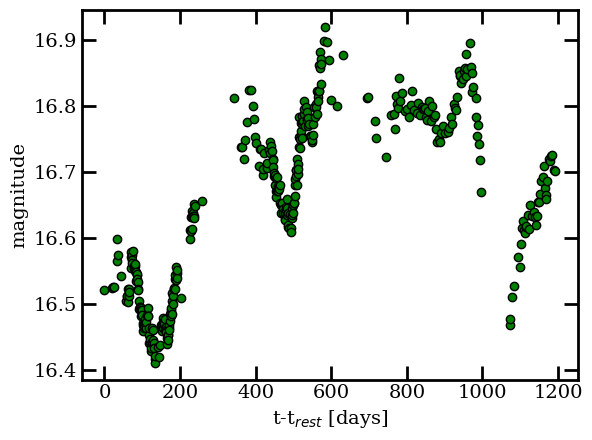

In [6]:
##################    
# plot light curve
################## 
t = df['MJD'].values
t = t - t[0]
y = df['Mag'].values

print(f'min dt: {np.min(t[1:] - t[:-1]):0.5f}' )
print(f'max dt: {np.max(t[1:] - t[:-1]):0.5f}' )
print(f'median dt: {np.median(t[1:] - t[:-1]):0.5f}' )
print(f'mean dt: {np.mean(t[1:] - t[:-1]):0.5f}' )

plt.figure()
plt.plot(t, y, linestyle="None", marker='o', markerfacecolor='g', markeredgecolor='k')
plt.xlabel(r't-t$_{rest}$ [days]')
plt.ylabel(r'magnitude')
plt.show()

In [7]:
##################  
# Inspecting the gaps in the light curve
##################  

dts = t[1:] - t[:-1]
bins = np.arange(np.min(dts), np.max(dts)+1, 1)
counts, _ = np.histogram(dts, bins=bins)

tiny_df = pd.DataFrame({"Bin Left Edge": bins[:-1], "Bin Right Edge": bins[1:], "Counts": counts})
tiny_df.loc[tiny_df['Counts']>0]

,Bin Left Edge,Bin Right Edge,Counts
0,0.816812,1.816812,207
1,1.816812,2.816812,50
2,2.816812,3.816812,61
3,3.816812,4.816812,18
4,4.816812,5.816812,4
5,5.816812,6.816812,13
6,6.816812,7.816812,7
7,7.816812,8.816812,4
8,8.816812,9.816812,2
9,9.816812,10.816812,2


In [8]:
# Looks like there are three places where there is a more than 50 day gap
print(np.where(dts > 50)[0])

[136 273 345]


In [9]:
# Picking out the second section of the light curve 
#    It's not necessary to do this, but the larger the seasonal gaps, the larger range of possible
#    distance values in the ozken distance matrix, which can make it difficult to determine appropriate
#    values for Lambda_S and the window size for making data segments for the ozken computation
y = y[137:273]
t = t[137:273]

print(f'min dt: {np.min(t[1:] - t[:-1]):0.5f}' )
print(f'max dt: {np.max(t[1:] - t[:-1]):0.5f}' )
print(f'median dt: {np.median(t[1:] - t[:-1]):0.5f}' )
print(f'mean dt: {np.mean(t[1:] - t[:-1]):0.5f}' )

min dt: 0.84688
max dt: 17.95484
median dt: 1.01961
mean dt: 2.01145


### Prepare for Ozken computation

In [10]:
##################    
# global variables
# these are required parameters for the ozken distance function
##################    
M = len(t)
total_time = max(t) - min(t)
Lambda_0 = M / total_time # inverse of the average dt
distances = squareform(pdist(np.reshape(y, (y.shape[0], 1)), metric='euclidean'))
Lambda_k = (M-1.0) / (np.sum(np.abs(y[:-1]-y[1:])))

print(f'total time: {total_time}')
print(f'average dt: {np.mean(t[1:]-t[:-1]):0.5f}')
print(f'M: {M}, Lambda 0: {Lambda_0:0.5f}, Lambda k: {Lambda_k:0.5f}')

total time: 271.5463542002035
average dt: 2.01145
M: 136, Lambda 0: 0.50084, Lambda k: 63.69940


number of data segments: 256
min data segment entries: 1
max data segment entries: 17
mean data segment entries: 8.9
median data segment entries: 9.0


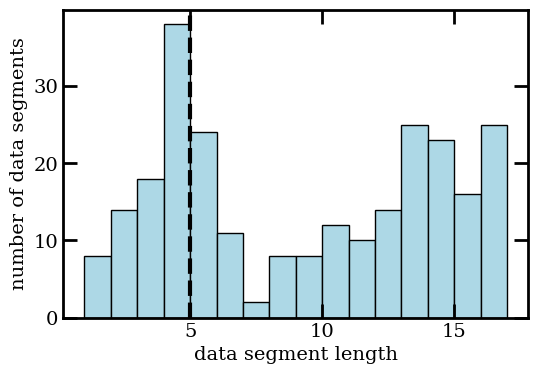

Number of data segments with at least 5 entries: 178


In [11]:
##################    
# get time series segments to compute Ozken RP
#     we want most data segments to have at least ~6ish entries, and none that are empty
#     max dt of the light curve is a good first choice
#     adjust window size as needed to accomplish this
##################    

# Split the time series into bins of equal width
win = 17.0 # window size (length of each time series segment)
dt = 1.0   # time step (size of increment between adjacent segments)

win_starts = np.arange(min(t), max(t)+dt-win, dt) # start times of each data segment
data_segments = np.array([np.where( (t >= i) & (t < i+win) )[0] for i in win_starts], dtype=object)

min_seg_length = min([q.size for q in data_segments])
max_seg_length = max([q.size for q in data_segments])

print(f'number of data segments: {len(data_segments)}')
print(f'min data segment entries: {min_seg_length}')
print(f'max data segment entries: {max_seg_length}')
print(f'mean data segment entries: {np.nanmean([q.size for q in data_segments]):0.1f}')
print(f'median data segment entries: {np.median([q.size for q in data_segments])}')

data_segment_lengths = [q.size for q in data_segments]
bins_seg_lengths = np.arange(min_seg_length, max_seg_length+1, 1)

plt.figure(figsize=[6,4])
hist, bins, _ = plt.hist(data_segment_lengths, bins=bins_seg_lengths,
                        color='lightblue', edgecolor='black', align='mid')
plt.axvline(x=5, color='k', linewidth=3.0, linestyle='--')
plt.xlabel('data segment length')
plt.ylabel('number of data segments')
plt.show()

print(f'Number of data segments with at least 5 entries: {np.sum(hist[np.where(bins>4)[0][:-1]]):0.0f}')

Processing 32896 pairs using joblib with -1 jobs
28.29102360265243


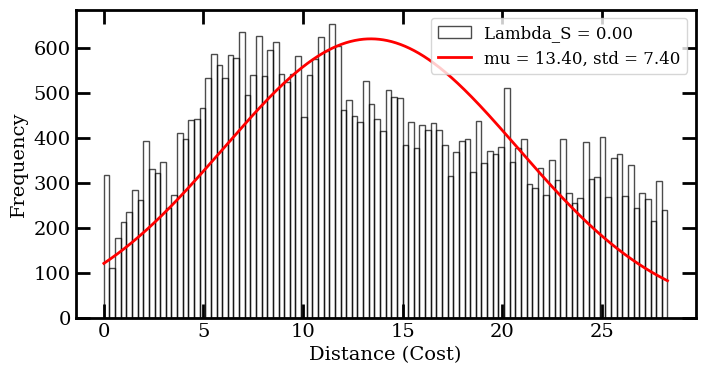

Processing 32896 pairs using joblib with -1 jobs
32.29102360265243


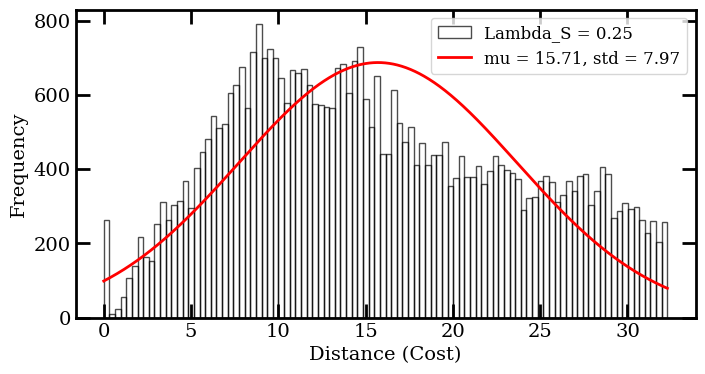

Processing 32896 pairs using joblib with -1 jobs
36.29102360265243


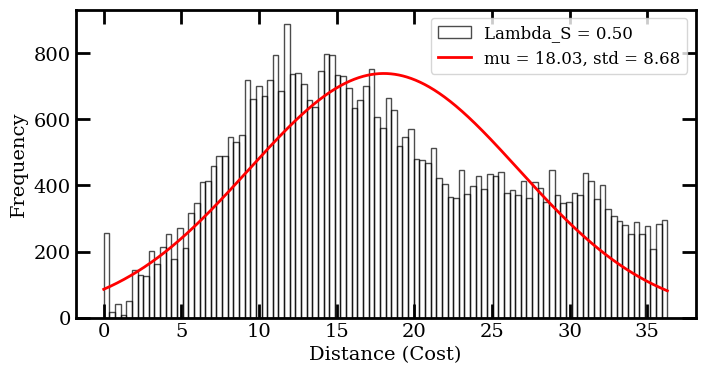

Processing 32896 pairs using joblib with -1 jobs
40.29102360265243


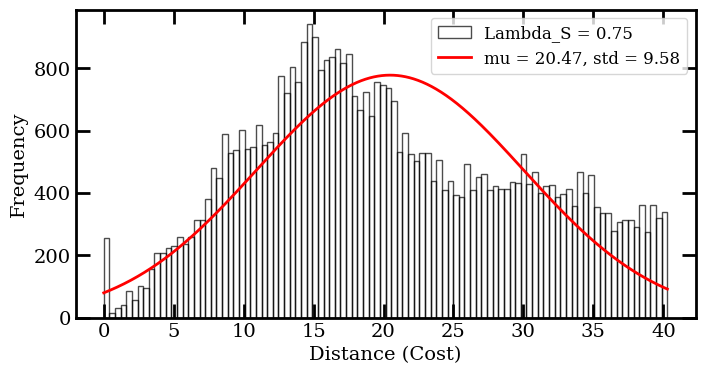

Processing 32896 pairs using joblib with -1 jobs
44.29102360265243


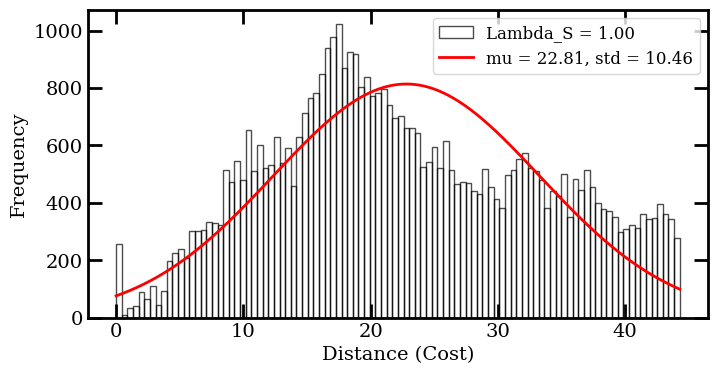

Processing 32896 pairs using joblib with -1 jobs
48.29102360265243


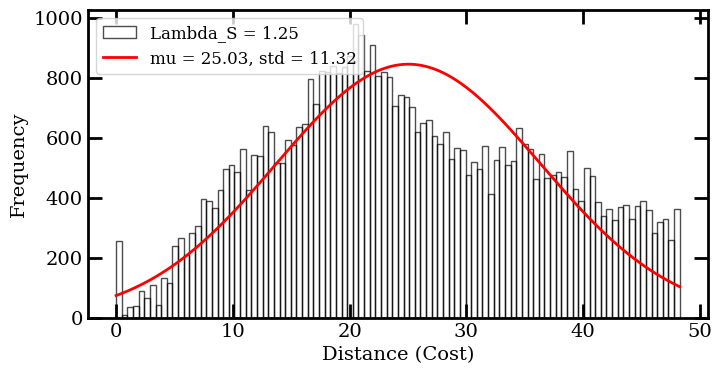

Processing 32896 pairs using joblib with -1 jobs
52.29102360265243


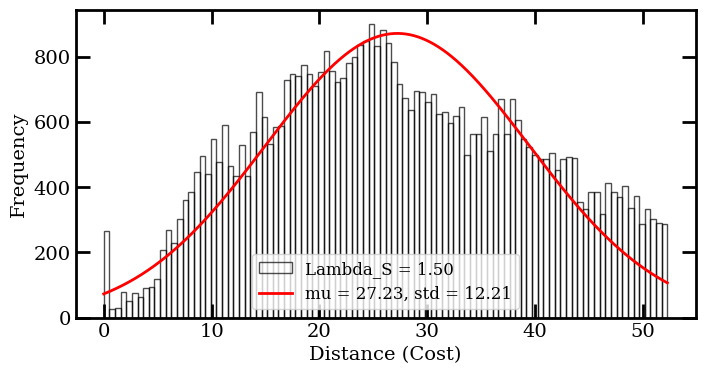

Processing 32896 pairs using joblib with -1 jobs
56.29102360265243


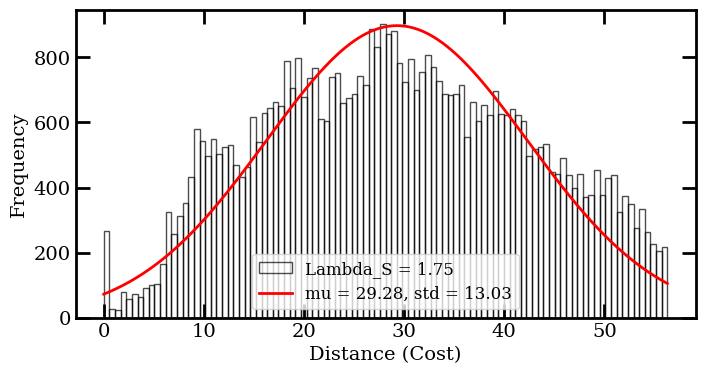

Processing 32896 pairs using joblib with -1 jobs
60.29102360265243


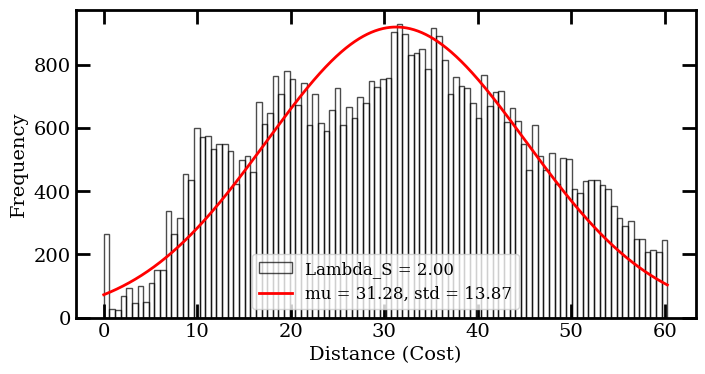

Processing 32896 pairs using joblib with -1 jobs
64.29102360265243


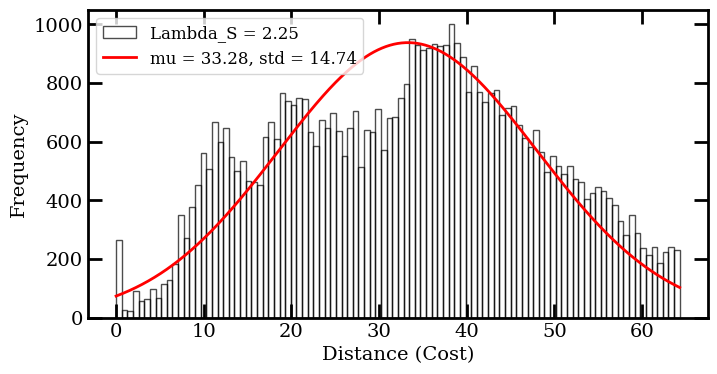

Processing 32896 pairs using joblib with -1 jobs
68.29102360265243


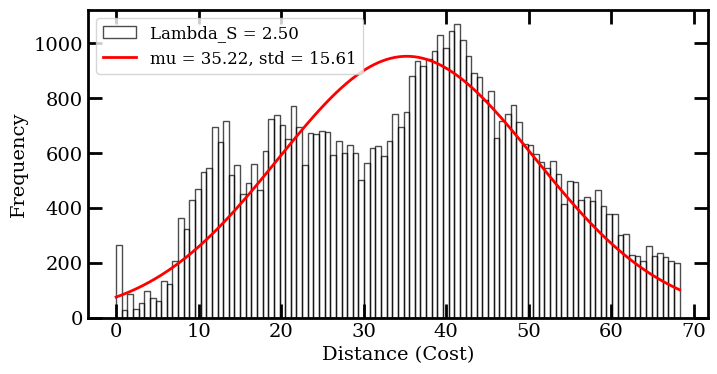

Processing 32896 pairs using joblib with -1 jobs
72.29102360265243


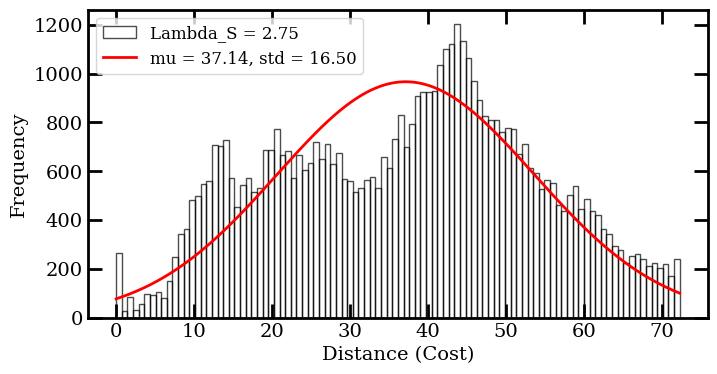

Processing 32896 pairs using joblib with -1 jobs
76.29102360265243


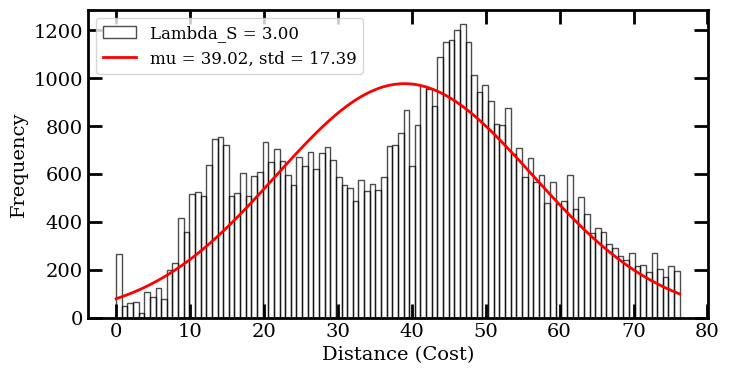

Processing 32896 pairs using joblib with -1 jobs
80.29102360265243


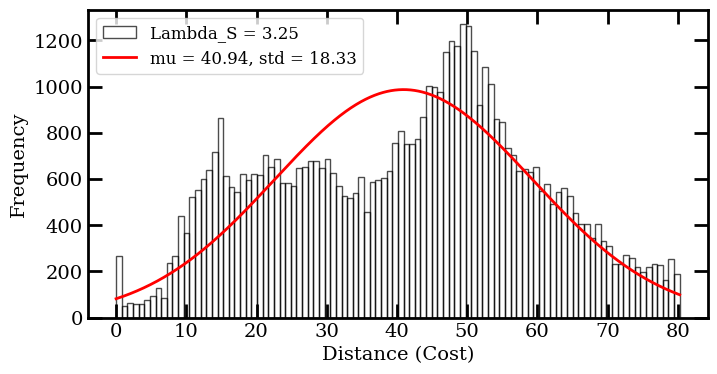

Processing 32896 pairs using joblib with -1 jobs
84.29102360265242


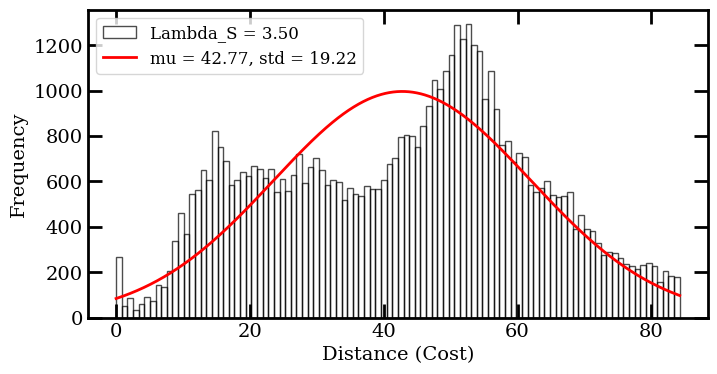

Processing 32896 pairs using joblib with -1 jobs
88.29102360265242


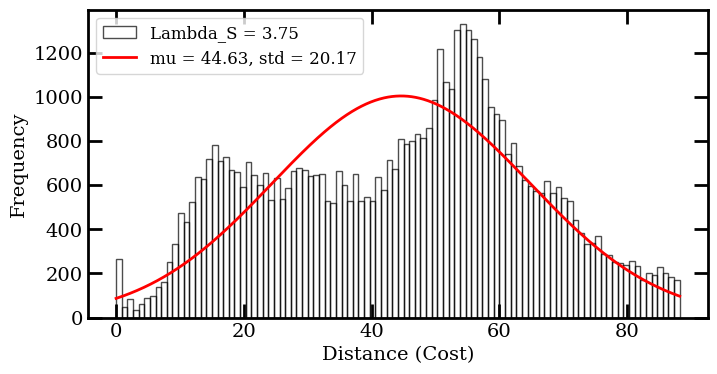

In [12]:
#############################################
# Determine choice for Lambda_S
#############################################
# The unknown parameter Lambda_S is determined by computing D (ozken_distance function)
#     for tests of Lambda_S in the range [0,4] in steps of 0.01.
#     The correct choice of Lambda_S is one in which the distances 
#     for all the segments is normally distributed (according to Ozken et al. 2018)
#
# The larger the seasonal gaps in the light curve, the more the distribution of distances
#     becomes heavily skewed, regardless of choice of Lambda_S.
#     However, this may not actually matter, since values being independent does *not* necessitate a gaussian distribution.
# 
# Ultimately, Lambda_S dictates how strongly weighted the adding/deleting operation is in the cost function.
#    If the histogram of data segment lengths has a massive range (e.g., if you do not rebin to daily observations, then you
#    could have some time series segments with a huge number of entries compared to others), then the similarity of data segments with 
#    significantly different numbers of entries will have very high cost.
# 
# *** WARNING *** This can take a long time 

#data_segments_subset = data_segments[:20]

lambda_S_arr = np.arange(0, 4.0, 0.25)

for Lambda_S in lambda_S_arr:

    with suppress_omp_output():
       od = ozken_distance_parallel(y, t, data_segments, dt=dt, L0=Lambda_0, Lk=Lambda_k, Ls=Lambda_S, backend="threading")

    # Excluding extreme distances (e.g., like those between segments with only 1 entry and the max number of entries)
    #   this is a klugie mitigation for extreme skewness
    max_cost = Lambda_S*(min_seg_length + max_seg_length - 2) + win*Lambda_0 + (np.max(y)-np.min(y))*Lambda_k
    print(max_cost)
    
    data = od.flatten()
    data = data[np.isfinite(data)]
    mask = data < max_cost
    data = data[mask]
    
    # plot histogram of distances
    plt.figure(figsize=[8,4])
    vals, bin_edges, patches = plt.hist(data, bins=100, #density=True,
             edgecolor='k', facecolor='None', alpha=0.7, 
             label=f'Lambda_S = {Lambda_S:.2f}')

    # fit a gaussian to the histogram
    bin_width = bin_edges[1] - bin_edges[0]    
    mu = np.mean(data)
    std = np.std(data)  
    x = np.linspace(np.min(data), np.max(data), 1000)
    fitted_pdf = norm.pdf(x, loc=mu, scale=std)
    fitted_counts = fitted_pdf * len(data) * bin_width
    plt.plot(x, fitted_counts, color='red', linewidth=2, 
             label=f'mu = {mu:.2f}, std = {std:.2f}')
    
    plt.legend(fontsize=12)
    plt.xlabel('Distance (Cost)')
    plt.ylabel('Frequency')
    plt.show()

### Compute Ozken RP

In [13]:
##################    
# create Ozken RP
################## 

Lambda_S = 1.0 # default

start_time = time.time()

## parallel version 
with suppress_omp_output():
    od = ozken_distance_parallel(y, t, data_segments, dt=dt, L0=Lambda_0, Lk=Lambda_k, Ls=Lambda_S, backend="threading")

## serial version 
# od = ozken_distance_serial(y, t, data_segments, dt=dt, L0=Lambda_0, Lk=Lambda_k, Ls=Lambda_S, progress_interval=10000)

elapsed = time.time() - start_time
print(f"Computation completed in {elapsed:.2f} seconds")

threshold = threshold_from_recurrence_rate(od, 0.15)
rp_full = threshold_by_distance(od, threshold)

Processing 32896 pairs using joblib with -1 jobs
Computation completed in 1.57 seconds


In [14]:
print(f'min distance in od: {np.min(od)}')
print(f'max distance in od: {np.max(od)}')
print(f'median distance in od: {np.median(od)}')

min distance in od: 0.0
max distance in od: 194.71019074619548
median distance in od: 27.913438321584387


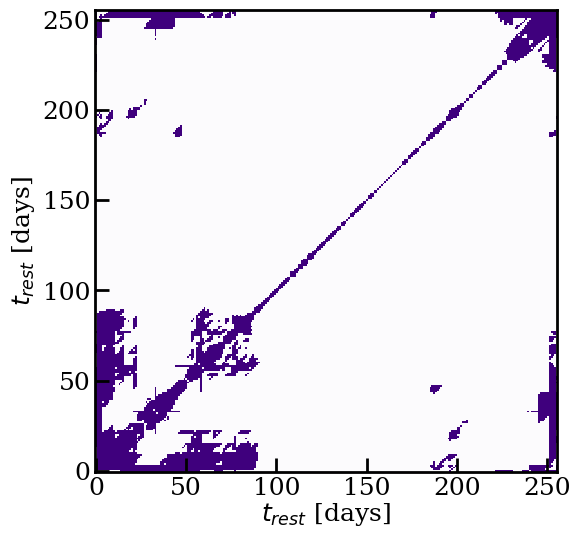

In [15]:
##################    
# Plot the RP
################## 
fig, ax = plt.subplots(figsize=(6,6), linewidth=3)

ax.matshow(rp_full, cmap='Purples')
ax.grid(False)
plt.gca().invert_yaxis()
fontsize=18
ax.set_xlabel(r"$t_{rest}$ [days]", fontsize=fontsize)
ax.set_ylabel(r"$t_{rest}$ [days]", fontsize=fontsize)                                                            
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.tick_params(bottom=True, top=False, left=True, right=False)
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.xaxis.labelpad = 1
plt.tight_layout()
plt.show()